In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings
import statsmodels.api as sm

#import the data
df_hf=pd.read_excel('/Users/luxueqi/Desktop/proshares_analysis_data.xlsx',sheet_name='hedge_fund_series',index_col=0)
df_mf=pd.read_excel('/Users/luxueqi/Desktop/proshares_analysis_data.xlsx',sheet_name='merrill_factors',index_col=0)
df_o=pd.read_excel('/Users/luxueqi/Desktop/proshares_analysis_data.xlsx',sheet_name='other_data',index_col=0)

In [77]:
#Question 1
def performance(dataframe):
    #mean
    dataframe_mean=dataframe.mean()*12
    #volatility
    dataframe_std=dataframe.std()*(np.sqrt(12))
    #sharpe ratio
    dataframe_sr=dataframe_mean/dataframe_std
    df = pd.DataFrame({
    'mean': dataframe_mean,
    'volatility': dataframe_std,
    'sharpe ratio': dataframe_sr
    })
    return df
performance(df_hf)

,mean,volatility,sharpe ratio
HFRIFWI Index,0.041447,0.060416,0.686023
MLEIFCTR Index,0.030670,0.057147,0.536686
MLEIFCTX Index,0.029239,0.056985,0.513102
HDG US Equity,0.019442,0.059589,0.326268
QAI US Equity,0.016958,0.049895,0.339873


In [141]:
#Question2
#function in week1 Risk and Return
def mdd_timeseries(rets):
    cum_rets = (1 + rets).cumprod()
    rolling_max = cum_rets.cummax()
    drawdown = (cum_rets - rolling_max) / rolling_max
    return cum_rets,rolling_max,drawdown



def performance_two(dataframe):
    #Skewness
    dataframe_s=dataframe.skew()
    #Kurtosis
    dataframe_k=dataframe.kurtosis()
    #the fifth quantile of historic returns
    dataframe_q=dataframe.quantile(.05)
    #the mean of the returns at or below the fifth quantile
    worst_returns =  dataframe[dataframe <= dataframe_q]
    CVaR_95 = worst_returns.mean()
    #Maximum drawdown
    cum, rolling_max, drawdown = mdd_timeseries(dataframe)
    #find the maximum drawdown by finding the minimum index
    date_min=drawdown.idxmin()
    #from 2023 soln:
    recovery_date = []
    date_max=[]
    for col in cum.columns:
        date_max.append(rolling_max[col][: drawdown[col].idxmin()].idxmax())
        prev_max = rolling_max[col][: drawdown[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([cum[col][drawdown[col].idxmin() :]]).T
        recovery_date.append(
            recovery_wealth[recovery_wealth[col] >= prev_max].index.min()
        )
    Recovery = ["-" if pd.isnull(i) else i for i in recovery_date]

    df = pd.DataFrame({
    'Skewness': dataframe_s,
    'Kurtosis': dataframe_k,
    'fifth quantile': dataframe_q,
    'below the 5th': CVaR_95,
    'min(max_drawdown)': date_min,
    'max' :date_max,
    'recovery' :Recovery
    })
    return df
performance_two(df_hf)   

,Skewness,Kurtosis,fifth quantile,below the 5th,min(max_drawdown),max,recovery
HFRIFWI Index,-0.979063,5.955123,-0.025324,-0.037478,2020-03-31,2019-12-31,2020-08-31 00:00:00
MLEIFCTR Index,-0.244981,1.689648,-0.028764,-0.035857,2022-09-30,2021-06-30,-
MLEIFCTX Index,-0.231032,1.657903,-0.029119,-0.035816,2022-09-30,2021-06-30,-
HDG US Equity,-0.233880,1.799098,-0.031209,-0.037577,2022-09-30,2021-06-30,-
QAI US Equity,-0.461338,1.825993,-0.020593,-0.032695,2022-09-30,2021-06-30,-


In [160]:
#Question 3
#TA
# Market Beta, Treynor Ratio, Information ratio
names=['HFRIFWI Index','MLEIFCTR Index','MLEIFCTX Index','HDG US Equity','QAI US Equity']
def reg_SPY(name):
    
    vs_index = df_hf[name]
    spy = df_mf["SPY US Equity"]

    vs_regr = sm.OLS(vs_index, sm.add_constant(spy)).fit()
    downside_mask = vs_index < 0
    
    summary = dict()
    summary["alpha"] = vs_regr.params["const"] * 12
    summary["beta"] = vs_regr.params["SPY US Equity"]
    summary["information ratio"] = (vs_regr.params.iloc[0] / vs_regr.resid.std()) * np.sqrt(12)
    summary["r_squared"] = vs_regr.rsquared
    summary["treynor ratio"] = (vs_index.mean() / summary["beta"]) * 12
    summary["tracking_error"] = vs_regr.params[0] / summary["information ratio"]
    
    spy_downside = spy[downside_mask].dropna()
    vs_downside = vs_index[downside_mask].dropna()

    summary["downside_beta"] = (
        sm.OLS(vs_downside, sm.add_constant(spy_downside)).fit().params["SPY US Equity"]
    )
    
    return(pd.DataFrame(summary, index=[name]))

for i in range(5):
    display(reg_SPY(names[i]))


,alpha,beta,information ratio,r_squared,treynor ratio,tracking_error,downside_beta
HFRIFWI Index,-0.003559,0.348217,-0.10952,0.710668,0.119027,0.002708,0.291382


,alpha,beta,information ratio,r_squared,treynor ratio,tracking_error,downside_beta
MLEIFCTR Index,-0.014549,0.349859,-0.571877,0.801824,0.087664,0.00212,0.290561


,alpha,beta,information ratio,r_squared,treynor ratio,tracking_error,downside_beta
MLEIFCTX Index,-0.015806,0.348514,-0.620547,0.800212,0.083896,0.002123,0.288664


,alpha,beta,information ratio,r_squared,treynor ratio,tracking_error,downside_beta
HDG US Equity,-0.027027,0.359536,-0.964387,0.778808,0.054075,0.002335,0.281827


,alpha,beta,information ratio,r_squared,treynor ratio,tracking_error,downside_beta
QAI US Equity,-0.021053,0.294096,-0.832728,0.743252,0.057662,0.002107,0.216788


In [162]:
##Question 4
#Q4(a):
spy = df_mf["SPY US Equity"]
df_with_spy = pd.concat([df_hf, spy], axis=1)
display(performance(df_with_spy))
performance_two(df_with_spy)

,mean,volatility,sharpe ratio
HFRIFWI Index,0.041447,0.060416,0.686023
MLEIFCTR Index,0.030670,0.057147,0.536686
MLEIFCTX Index,0.029239,0.056985,0.513102
HDG US Equity,0.019442,0.059589,0.326268
QAI US Equity,0.016958,0.049895,0.339873
SPY US Equity,0.129248,0.146265,0.883658


,Skewness,Kurtosis,fifth quantile,below the 5th,min(max_drawdown),max,recovery
HFRIFWI Index,-0.979063,5.955123,-0.025324,-0.037478,2020-03-31,2019-12-31,2020-08-31 00:00:00
MLEIFCTR Index,-0.244981,1.689648,-0.028764,-0.035857,2022-09-30,2021-06-30,-
MLEIFCTX Index,-0.231032,1.657903,-0.029119,-0.035816,2022-09-30,2021-06-30,-
HDG US Equity,-0.233880,1.799098,-0.031209,-0.037577,2022-09-30,2021-06-30,-
QAI US Equity,-0.461338,1.825993,-0.020593,-0.032695,2022-09-30,2021-06-30,-
SPY US Equity,-0.405414,0.796696,-0.068837,-0.086619,2022-09-30,2021-12-31,-


In [ ]:
#analysis:

In [167]:
#Q4(b):
df_hf[["HDG US Equity", "QAI US Equity"]].corr()

,HDG US Equity,QAI US Equity
HDG US Equity,1.000000,0.876684
QAI US Equity,0.876684,1.000000


In [ ]:
#analysis

In [182]:
#Q4(c)
#the 'performance' comparison

new_names=['MLEIFCTR Index','MLEIFCTX Index','HDG US Equity']

def reg_HERI(name):
    
    heri = df_hf['HFRIFWI Index']  #y
    vs_index = df_hf[name]  #X
    vs_regr = sm.OLS(heri, sm.add_constant(vs_index)).fit()
    
    summary = dict()
    summary["alpha"] = vs_regr.params["const"] * 12
    summary["beta"] = vs_regr.params[name]
    summary["information ratio"] = (vs_regr.params.iloc[0] / vs_regr.resid.std()) * np.sqrt(12)
    summary["r_squared"] = vs_regr.rsquared
    summary["treynor ratio"] = (heri.mean() / summary["beta"]) * 12
    summary["tracking_error"] = vs_regr.params[0] / summary["information ratio"]
    return(pd.DataFrame(summary, index=[name]))

for i in range(3):
    display(reg_HERI(new_names[i]))


,alpha,beta,information ratio,r_squared,treynor ratio,tracking_error
MLEIFCTR Index,0.012403,0.946981,0.461765,0.802341,0.043768,0.002238


,alpha,beta,information ratio,r_squared,treynor ratio,tracking_error
MLEIFCTX Index,0.0137,0.94898,0.508522,0.801157,0.043675,0.002245


,alpha,beta,information ratio,r_squared,treynor ratio,tracking_error
HDG US Equity,0.024008,0.896975,0.852416,0.782678,0.046208,0.002347


In [ ]:
#analysis

Min Corr (by absolute value): MLEIFCTX Index and USGG3M Index with a correlation of 0.01


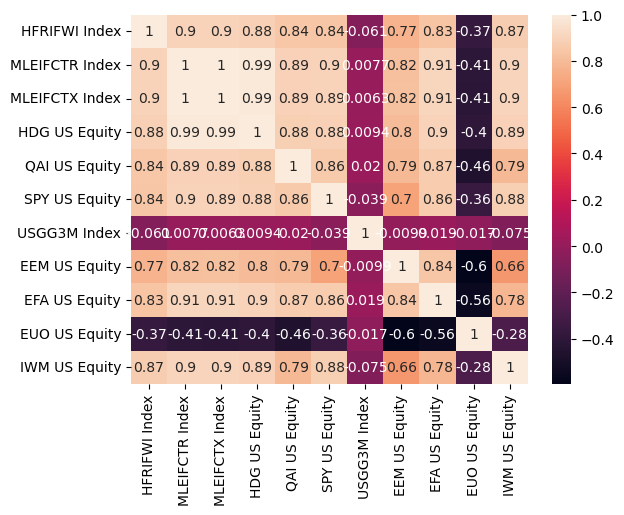

In [184]:
#Question5
corr_matrix = pd.concat([df_hf, df_mf], axis=1).corr()
sns.heatmap(corr_matrix,annot=True);

#Q5(b)
#obvious: MLEIFCTR Index and MLEIFCTX Index have the max correlation of 1; 
#EEM US Equity and EUO US Equity have the min correlation of -0.6
#from 2023:
def print_abs_min(corrs):
    corr_series = corrs.unstack()
    corr_series = corr_series[corr_series != 1]
    min_corr = corr_series.abs().agg(["idxmin", "min"]).T
    min_corr, min_corr_val = min_corr["idxmin"], min_corr["min"] 
    print(
        f"Min Corr (by absolute value): {min_corr[0]} and {min_corr[1]} with a correlation of {min_corr_val:.2f}"
    )
print_abs_min(corr_matrix)    

In [186]:
#Question6
#Q6(a),(c),(d):
#by 2023
#without interception:
y=df_hf["HFRIFWI Index"]
X=df_mf
model = sm.OLS(y, X, missing="drop")
results = model.fit()
summary = dict()
inter = 0 
betas = results.params
summary["Alpha"] = inter * 12
summary["R-Squared"] = results.rsquared
X_cols = X.columns

for i, col in enumerate(X_cols):
    summary[f"{col} Beta"] = betas[i]
    summary["Information Ratio"] = (inter / results.resid.std()) * np.sqrt(12)
    summary["Tracking Error"] = (
        results.resid.std() * np.sqrt(12)
    )
display(pd.DataFrame(summary, index=[y.name]))

#with interception
X_p = sm.add_constant(X)
results_p = (sm.OLS(y, X_p, missing="drop")).fit()
summary_p = dict()
inter_p = results_p.params[0]
betas_p = results_p.params[1:]
summary_p["Alpha"] = inter_p * 12
summary_p["R-Squared"] = results_p.rsquared
X_p_cols = X_p.columns[1:]
for i, col in enumerate(X_p_cols):
    summary_p[f"{col} Beta"] = betas_p[i]
    summary_p["Information Ratio"] = (inter_p / results_p.resid.std()) * np.sqrt(12)
    summary_p["Tracking Error"] = (
        inter_p / summary_p["Information Ratio"]
    )
display(pd.DataFrame(summary_p, index=[y.name]))

,Alpha,R-Squared,SPY US Equity Beta,Information Ratio,Tracking Error,USGG3M Index Beta,EEM US Equity Beta,EFA US Equity Beta,EUO US Equity Beta,IWM US Equity Beta
HFRIFWI Index,0,0.838049,0.049049,0.0,0.024592,0.245748,0.079039,0.075246,0.025851,0.150139


,Alpha,R-Squared,SPY US Equity Beta,Information Ratio,Tracking Error,USGG3M Index Beta,EEM US Equity Beta,EFA US Equity Beta,EUO US Equity Beta,IWM US Equity Beta
HFRIFWI Index,0.017794,0.836058,0.029963,0.727413,0.002039,-0.370915,0.079118,0.084161,0.023106,0.153294


In [ ]:
#Q6(b):